# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

# Import

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import pickle

In [53]:
df = pd.read_csv('../data/reviews_Model.csv')

In [54]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,...,neu_score,pos_score,compound_score,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,...,0.707,0.293,0.4404,9,3,20,26,47,8,Good Seller Service
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,...,0.408,0.592,0.4404,9,3,20,13,19,3,Good Overall Service
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase,first happy,purchase experience purchase,NaN,NaN,...,0.714,0.286,0.3400,9,3,20,11,57,7,Good Seller Service
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,...,0.715,0.285,0.4927,9,3,20,8,35,9,Good Overall Service
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,...,1.000,0.000,0.0000,9,3,19,37,16,3,Good Overall Service


In [55]:
df['word_count'].value_counts().head(10)

1     9572
2     8926
3     6157
4     5104
5     4505
6     3858
7     3275
8     2729
9     2381
10    2107
Name: word_count, dtype: int64

In [56]:
#list comprehension for target variable
df['rate'] = [1  if (df['rating'][i] > 3) else 0 for i in range(len(df['rating']))]

In [57]:
df['rate'].value_counts(normalize = True)

1    0.796452
0    0.203548
Name: rate, dtype: float64

In [58]:
#Checking null values
df.isna().sum()

rating                0
date                  0
app                   0
store                 0
review                0
clean_content         0
adj               14433
noun              22056
verb              31922
emoji             69984
neg_score             0
neu_score             0
pos_score             0
compound_score        0
month                 0
dayofweek             0
hour                  0
minute                0
text_len              0
word_count            0
category              0
rate                  0
dtype: int64

## Train Test Split Data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['rate'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['rate'])

In [60]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 59748, X_test rows: 14937
y_train rows: 59748, y_test rows: 14937


## Baseline Model

In [61]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(59748, 5000)
(14937, 5000)


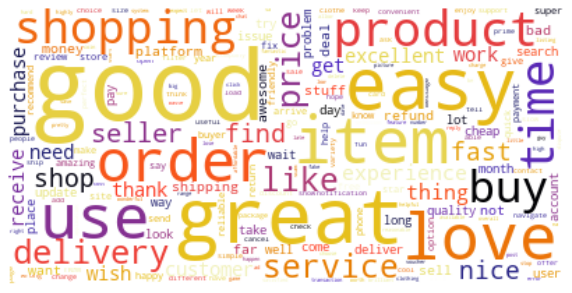

In [62]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [63]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.9295206534109929
Accuracy score for Test data set: 0.9120974760661444


In [64]:
preds = lr.predict(test_data_features)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print(f'Specificity: {round(tn / (tn + fp),4)}')
print(f'Sensitivity: {round(tp / (tp + fn),4)}')
print(f'MCC Score: {matthews_corrcoef(y_test,preds)}')

Specificity: 0.6947
Sensitivity: 0.9676
MCC Score: 0.7147274807138613


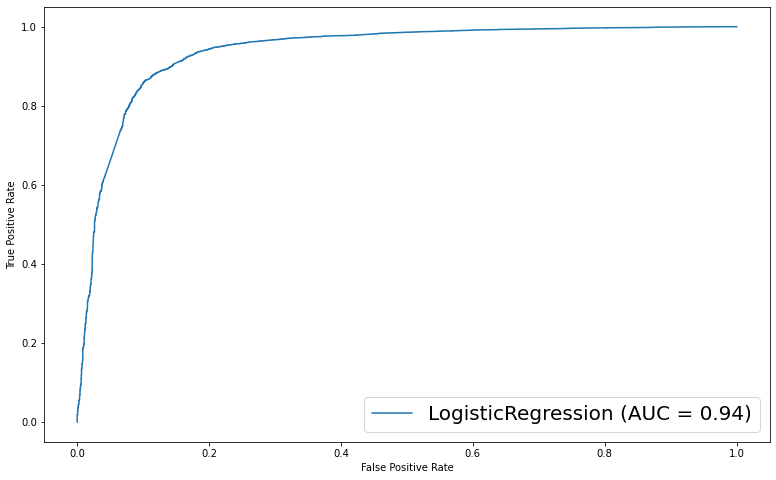

In [65]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(lr, test_data_features, y_test, ax = ax)
plt.legend(prop={"size":20});

## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [83]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [7000, 8000],
    'cvec__min_df': [3, 4],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = GridSearchCV(cvec_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  5.5min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.3, max_features=8000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  333.131s


### TFIDVectorizer Logistic Regression

In [84]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  5.0min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  301.631s


### HashingVectorizer Logistic Regression

In [85]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [6000, 7000],
    'hash__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = GridSearchCV(hash_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=7000)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  76.094s


In [86]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,CountVectorizer,0.941035,0.936672,0.708551,333
1,LogisticRegression,TFIDVectorizer,0.947139,0.943962,0.725383,302
2,LogisticRegression,HashingVectorizer,0.946131,0.942565,0.718897,76


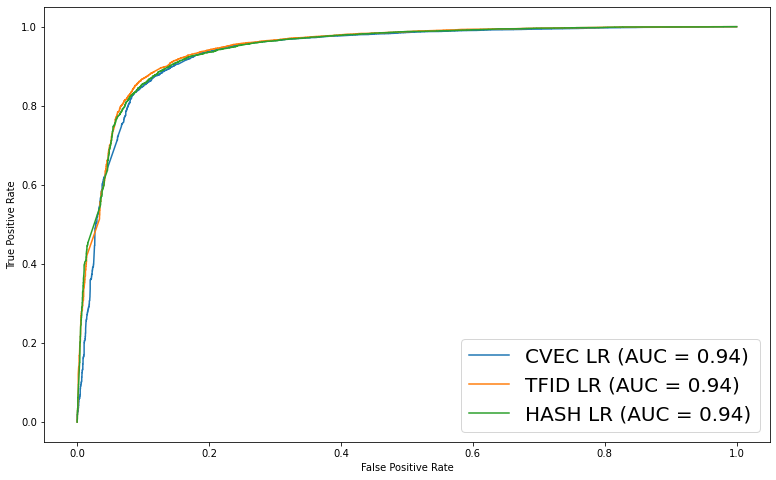

In [87]:
fig, ax = plt.subplots(figsize=(13, 8))
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, X_test, y_test, name = 'CVEC LR', ax = ax)
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFID LR', ax = ax)
hash_lr_disp = plot_roc_curve(gs_hash_lr, X_test, y_test, name = 'HASH LR', ax = ax)
plt.legend(prop={"size":20});

In [88]:
print('Best Vectorizer Classification Report')
pd.DataFrame(classification_report(y_test, 
                            gs_tfid_lr.predict(X_test),
                            target_names = ['Bad_Reviews', 'Good_reviews'], 
                            output_dict=True)).T

Best Vectorizer Classification Report


,precision,recall,f1-score,support
Bad_Reviews,0.825974,0.732237,0.776286,3040.000000
Good_reviews,0.933508,0.960578,0.946849,11897.000000
accuracy,0.914106,0.914106,0.914106,0.914106
macro avg,0.879741,0.846408,0.861568,14937.000000
weighted avg,0.911622,0.914106,0.912136,14937.000000


## Trying with Different Models

### Logistic Regression

In [21]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000,9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(2, 4, 5))
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_lr_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_lr_test_time);

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  6.7min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=2.5, max_iter=5000))])
Fit time:  403.297s


In [22]:
filename = 'tfid_lr.sav'
pickle.dump(gs_tfid_lr, open('./model_pickles/' + filename, 'wb'))

### MultinomialNB

In [23]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0.3,1,5))
}

gs_tfid_nb = GridSearchCV(tfid_nb, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_nb.fit(X_train, y_train)
tfid_nb_test_time = time() - t0
print(f'Best MultinomialNB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_nb_test_time);

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Best MultinomialNB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('nb', MultinomialNB(alpha=0.3))])
Fit time:  96.011s


In [24]:
filename = 'tfid_nb.sav'
pickle.dump(gs_tfid_nb, open('./model_pickles/' + filename, 'wb'))

### SVC

In [25]:
# Setting pipeline for two stages
tfid_svc = Pipeline([
    ('tfid', TfidfVectorizer(max_features = 8000, min_df = 3, max_df = 4, ngram_range = (1,2))),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('svc', SVC(C = 1.0, gamma = 'auto'))
])

pipe_params = {
    'svc__degree': [3, 4],
    'svc__kernel': ['rbf', 'linear'],
}

gs_tfid_svc = GridSearchCV(tfid_svc, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_svc.fit(X_train, y_train)
tfid_svc_test_time = time() - t0
print(f'Best SVC Parameters: {gs_tfid_svc.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_svc_test_time);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished


Best SVC Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=4, max_features=8000, min_df=3,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('svc', SVC(gamma='auto'))])
Fit time:  183.601s


In [26]:
filename = 'tfid_svc.sav'
pickle.dump(gs_tfid_nb, open('./model_pickles/' + filename, 'wb'))

### RandomForest

In [27]:
# Setting pipeline for two stages
tfid_ran = Pipeline([
    ('tfid', TfidfVectorizer(max_features = 9000, min_df = 3, max_df = 4, ngram_range = (1,2))),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ran', RandomForestClassifier(random_state = 42, min_samples_leaf = 2, min_samples_split = 3))
])

pipe_params = {
    'ran__n_estimators': [50, 75, 100],
}

gs_tfid_ran = GridSearchCV(tfid_ran, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_ran.fit(X_train, y_train)
tfid_ran_test_time = time() - t0
print(f'Best RandomForest Parameters: {gs_tfid_ran.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ran_test_time);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.3min finished


Best RandomForest Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=4, max_features=9000, min_df=3,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ran',
                 RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                                        random_state=42))])
Fit time:  181.178s


In [28]:
filename = 'tfid_ran.sav'
pickle.dump(gs_tfid_ran, open('./model_pickles/' + filename, 'wb'))

### Adaboost

In [29]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer(max_features = 8000, ngram_range = (1,2))),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'ada__n_estimators': [100,150,200],
    'ada__learning_rate': list(np.linspace(0.3,1,5))
}

gs_tfid_ada = GridSearchCV(tfid_ada, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
tfid_ada_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ada_test_time);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.9min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.6499999999999999,
                                    n_estimators=200))])
Fit time:  850.206s


In [30]:
filename = 'tfid_ada.sav'
pickle.dump(gs_tfid_ada, open('./model_pickles/' + filename, 'wb'))
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

### Accuracy & ROC AUC Score

In [31]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])

summary.append(['MultinomialNB', 'TFIDVectorizer', 
                gs_tfid_nb.best_score_,
                gs_tfid_nb.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_nb.predict(X_test)),
                round(tfid_nb_test_time)])

summary.append(['SVC', 'TFIDVectorizer', 
                gs_tfid_svc.best_score_,
                gs_tfid_svc.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_svc.predict(X_test)),
                round(tfid_svc_test_time)])

summary.append(['RandomForest', 'TFIDVectorizer', 
                gs_tfid_ran.best_score_,
                gs_tfid_ran.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ran.predict(X_test)),
                round(tfid_ran_test_time)])



summary.append(['Adaboost', 'TFIDVectorizer', 
                gs_tfid_ada.best_score_,
                gs_tfid_ada.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ada.predict(X_test)),
                round(tfid_ada_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

C:\Users\Sim Yi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.948032,0.944813,0.728877,403
1,MultinomialNB,TFIDVectorizer,0.947756,0.943269,0.721427,96
2,SVC,TFIDVectorizer,0.669216,0.658234,0.000000,184
3,RandomForest,TFIDVectorizer,0.683643,0.684689,0.329974,181
4,Adaboost,TFIDVectorizer,0.934504,0.931726,0.661356,850


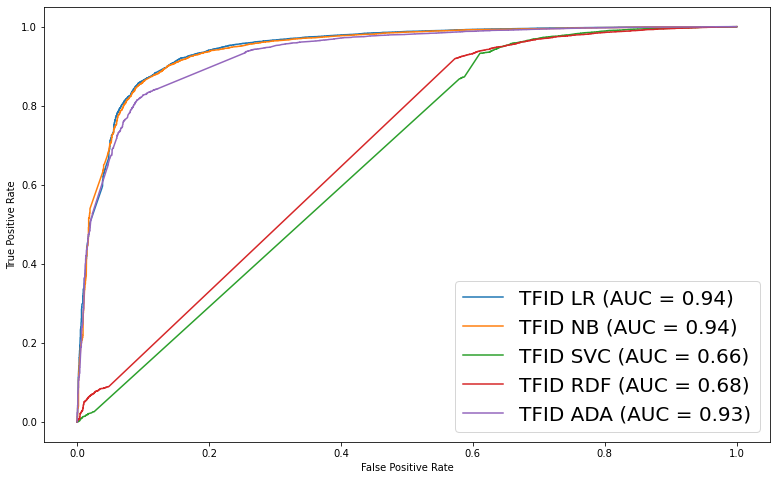

In [32]:
fig, ax = plt.subplots(figsize=(13, 8))
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFID LR', ax = ax)
tfid_nb_disp = plot_roc_curve(gs_tfid_nb, X_test, y_test, name = 'TFID NB', ax = ax)
tfid_svc_disp = plot_roc_curve(gs_tfid_svc, X_test, y_test, name = 'TFID SVC', ax = ax)
tfid_ran_disp = plot_roc_curve(gs_tfid_ran, X_test, y_test, name = 'TFID RDF', ax = ax)
tfid_ada_disp = plot_roc_curve(gs_tfid_ada, X_test, y_test, name = 'TFID ADA', ax = ax)
plt.legend(prop={"size":20});

## Confusion Matrix

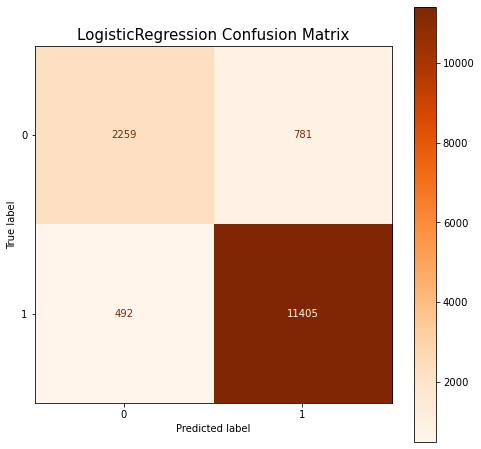

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax, cmap='Oranges');

In [34]:
good_reviews_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = False).reset_index(drop = True)

In [35]:
bad_reviews_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = True).reset_index(drop = True)

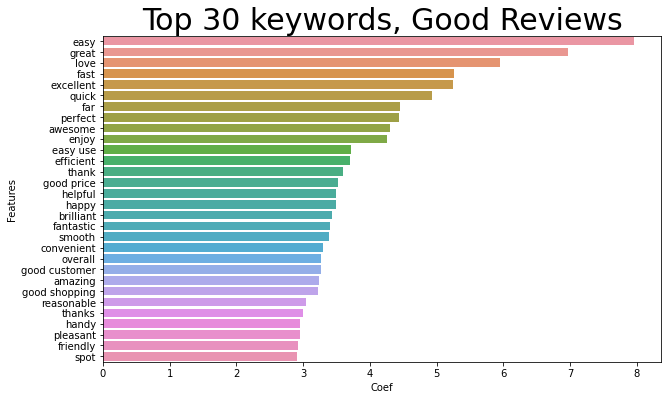

In [36]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 keywords, Good Reviews',fontdict = {'fontsize': 30})
sns.barplot(x = 'Coef', y = 'Features', data = good_reviews_bag[:30]);

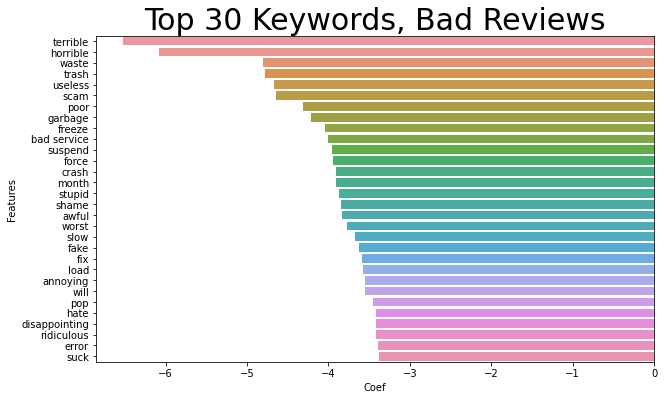

In [37]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 Keywords, Bad Reviews',fontdict = {'fontsize': 30})
sns.barplot(x = 'Coef', y = 'Features', data = bad_reviews_bag[:30]);

## Checking Misclassified Post

In [38]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(X_test), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test

# Check out first five rows.
results.head()

,predicted,actual
55450,1,1
71520,1,1
60078,1,1
4619,0,0
29824,0,0


In [39]:
# Find all indices where predicted and true results 
# aren't the same, then save in an array.
row_ids = results[results['predicted']!= results['actual']].index
row_ids

Int64Index([47017,  4007, 74236, 32349, 48584, 41466, 66011, 19019, 50561,
            45740,
            ...
            52040, 26427, 68738, 47003,  5407,  8140, 32250, 64607, 64658,
            40814],
           dtype='int64', length=1273)

In [50]:
i = 8
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 50561
----
Bring back Filter Orders>Open Orders. I have no idea why this would be removed, but makes keeping track of open orders much easier.
----
bring filter > open order idea remove make keeping track open order easy
----
Actual thread: 0


In [51]:
i = 6
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 66011
----
Excellent
----
excellent
----
Actual thread: 0


In [48]:
i = 2
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 74236
----
Just wish more products at lower cost can be included as I can see some offering in 淘宝网 is not available in this app
----
wish product low cost include offering available
----
Actual thread: 0


In [47]:
i = 7
print(f'Post ID: {row_ids[i]}')
print('----')
print(df['review'][row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 19019
----
HEY TIGIL NYO NGA YUNG SAPILITANG PAGPAPADOWNLOAD NG APP NATO. DI AKO MAKAPAG DOWNLOAD NG VIDEOS NG DI TO DINADOWNLOAD NAKAKAUMAY PO.
----
hey di ako di po
----
Actual thread: 0


## Train data on whole dataset

In [44]:
best_model = gs_tfid_lr.best_estimator_

In [45]:
best_model.fit(df['clean_content'], df['rating'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=2.5, max_iter=5000))])

In [46]:
filename = 'Best_Model_P1.sav'
pickle.dump(best_model, open('./model_pickles/' + filename, 'wb'))